<a href="https://colab.research.google.com/github/evroth/gsb545repo/blob/main/Lab4_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Predicting Heart Disease

Using the Behavioral Risk Factor Surveillance System (BRFSS) from the CDC and boosting to predict heart disease.

## The Data

In [1]:
import pandas as pd

df = pd.read_csv("heart_2020_cleaned.csv")

In [2]:
df.sample(5)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
109942,No,29.26,Yes,No,No,20.0,30.0,Yes,Female,60-64,White,No,No,Fair,5.0,No,No,No
215594,No,32.28,No,No,No,0.0,0.0,No,Male,50-54,Black,No,No,Good,8.0,No,No,No
154831,No,16.50,Yes,No,No,0.0,0.0,No,Male,75-79,White,No,Yes,Good,8.0,No,No,No
277593,No,20.36,No,Yes,No,0.0,0.0,No,Female,50-54,White,No,Yes,Excellent,8.0,No,No,No
57489,No,27.12,No,No,No,1.0,2.0,No,Male,35-39,White,No,Yes,Excellent,7.0,No,No,No


In [4]:
df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


In [5]:
df.nunique()

HeartDisease           2
BMI                 3604
Smoking                2
AlcoholDrinking        2
Stroke                 2
PhysicalHealth        31
MentalHealth          31
DiffWalking            2
Sex                    2
AgeCategory           13
Race                   6
Diabetic               4
PhysicalActivity       2
GenHealth              5
SleepTime             24
Asthma                 2
KidneyDisease          2
SkinCancer             2
dtype: int64

## Exploratory Analysis

In [6]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

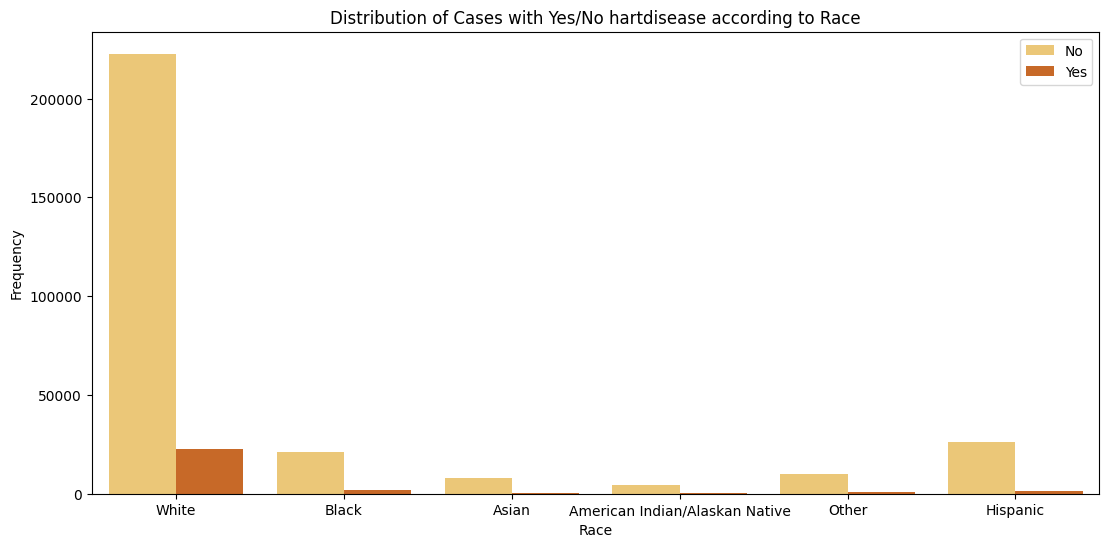

In [16]:
plt.figure(figsize = (13,6))
sns.countplot( x= df['Race'], hue = 'HeartDisease', data = df, palette = 'YlOrBr')
plt.title("Distribution of Cases with Yes/No hartdisease according to Race")
plt.xlabel('Race')
plt.legend()
plt.ylabel('Frequency')
plt.show()

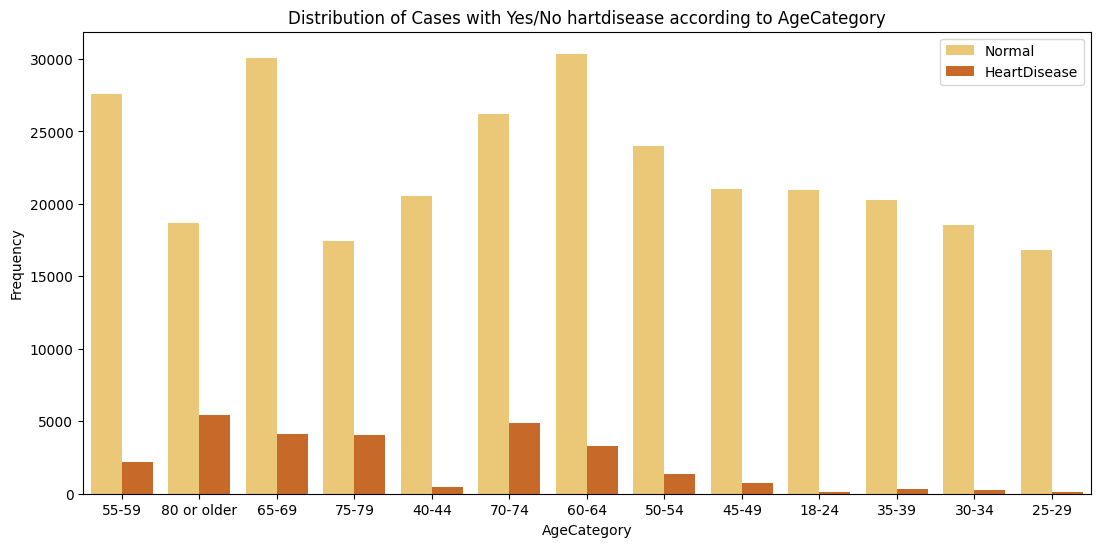

In [15]:
plt.figure(figsize = (13,6))
sns.countplot(x = df['AgeCategory'], hue = 'HeartDisease', data = df, palette = 'YlOrBr')
plt.title("Distribution of Cases with Yes/No hartdisease according to AgeCategory")
plt.xlabel('AgeCategory')
plt.legend(['Normal','HeartDisease'])
plt.ylabel('Frequency')
plt.show()

## Preprocessing

In [21]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
df['HeartDisease'] = le.fit_transform(df['HeartDisease'])
df['Smoking'] = le.fit_transform(df['Smoking'])
df['AlcoholDrinking'] = le.fit_transform(df['AlcoholDrinking'])
df['Stroke'] = le.fit_transform(df['Stroke'])
df['DiffWalking'] = le.fit_transform(df['DiffWalking'])
df['Sex'] = le.fit_transform(df['Sex'])
df['AgeCategory'] = le.fit_transform(df['AgeCategory'])
df['Race'] = le.fit_transform(df['Race'])
df['Diabetic'] = le.fit_transform(df['Diabetic'])
df['PhysicalActivity'] = le.fit_transform(df['PhysicalActivity'])
df['GenHealth'] = le.fit_transform(df['GenHealth'])
df['Asthma'] = le.fit_transform(df['Asthma'])
df['KidneyDisease'] = le.fit_transform(df['KidneyDisease'])
df['SkinCancer'] = le.fit_transform(df['SkinCancer'])

In [22]:
# Separate features and target variable
X = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease']

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import multiprocessing

if __name__ == "__main__":
    print("Parallel Parameter optimization")
    xgb_model = XGBClassifier(n_jobs=multiprocessing.cpu_count() // 2)
    clf = GridSearchCV(xgb_model, {'max_depth': [1, 2, 4, 6],
                                   'n_estimators': [20, 50, 100]}, verbose=1,
                       n_jobs=-1, cv=5)
    clf.fit(X, y)
    print(clf.best_score_)
    print(clf.best_params_)

Parallel Parameter optimization
Fitting 5 folds for each of 12 candidates, totalling 60 fits


The above takes too long to run so I will try doing other things

*Note:* To address the imbalance of the response variable, I will use the metric ROC AUC to balanace accuracy, percision, and recall of the models. If we were to just always guess no heart disease for every observation we could expect an accuracy rate of approximately 91% depending on the sample.

**Model 1: XGBoost**

In [49]:
from xgboost import XGBClassifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# define the model
model = XGBClassifier()
# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
# evaluate the model on the dataset
n_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# report performance
print('ROC Area Under Curve: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

ROC Area Under Curve: 0.840 (0.002)


This model also had an acuracy rate of .916 which was tied for the highest of the three models explored. Since it took so long to run I did not rerun it but wrote it down, just change the scoring method back to accuracy if wanted.

**Model 2: Gradient Boost**

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

# define the model
model = GradientBoostingClassifier()
# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=2, random_state=1)
# evaluate the model on the dataset
n_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# report performance
print('ROC Area Under Curve: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

ROC Area Under Curve: 0.842 (0.001)


This model, has a higher AUC than the first model by .002

This model also had an acuracy rate of .916 which was tied with the previous model.

**Model 3: AdaBoost**

In [51]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(n_estimators=3, algorithm="SAMME",
                              random_state=0)
cross_val_score(model,X,y,scoring="roc_auc",cv=5).mean()

0.7327562136620154

This model has the lowest of the three in terms of AUC, it also had a slightly smaller accuracy than the other two. This could be due to the sampling or other tweaked factors

## Important Variables

[Text(0.5, 0.8333333333333334, 'AgeCategory <= 7.5\ngini = 0.157\nsamples = 319795\nvalue = [292422, 27373]'),
 Text(0.25, 0.5, 'Stroke <= 0.5\ngini = 0.062\nsamples = 175258\nvalue = [169658, 5600]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.053\nsamples = 172276\nvalue = [167572, 4704]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.42\nsamples = 2982\nvalue = [2086, 896]'),
 Text(0.75, 0.5, 'Stroke <= 0.5\ngini = 0.256\nsamples = 144537\nvalue = [122764, 21773]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.233\nsamples = 135450\nvalue = [117170, 18280]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.473\nsamples = 9087\nvalue = [5594, 3493]')]

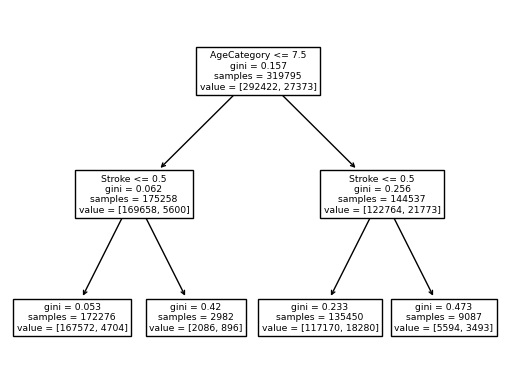

In [45]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

features = ['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', 'Race',
            'Diabetic', 'PhyicalActivity', 'GenHealth', 'SleepTime', 'Asthma', 'KidneyDisease', 'SkinCancer']

dtree = DecisionTreeClassifier(max_depth = 2)
dtree = dtree.fit(X, y)

tree.plot_tree(dtree,feature_names=features)

In [47]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'No': 0, 'Yes': 1}


With the code above I am trying to figure out how to re-map the label encoded columns to see which age categories are 7 or less and which are more than 7 to understand where the age cutoff is.

Regardless, we can take away from this simple tree that age is the most significant variable to determine if someone has heart disease, followed by if they had a stroke.